In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
plt.style.use('cyberpunk')

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import nn, optim

print(torch.__version__)

2.0.0+cu117


In [2]:
alphabet = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

data = pd.read_csv("protenomes_proteins.csv")

from data_process import concat_data
data, classes = concat_data([data])

In [3]:
data.head()

,Class,Sequence
0,virus,METNKNTYSRIVDTVEPITAVAFTIYSNTDVVKYSAISDPNGITVA...
1,virus,MNTDWKNTSLVDLENKIIKFWRNIDATKKVLEKTKNYPKKNFLDGP...
2,virus,MSKKSKEVEDVNSNYDSEPFFGLLDLFFERNNQILVSHHIESFNQL...
3,virus,MELSQNFQKYFSIENPNKITKILRKNDHTNDKYEWIVLEKIHGANF...
4,virus,MENITQLVNNYLRGCISSCFPQVINVNEYSVIKSNKHDYQFNRLAH...


In [4]:
classes

{'virus': 0, 'archaea': 1, 'eucariote': 2, 'bacteria': 3}

### Build vocabulary for label encoder or k-mers encoder

In [5]:
from data_process import build_bin_vocab, build_kmer_vocab

bin_vocab = build_bin_vocab(alphabet)

k=3
kmer_vocab = build_kmer_vocab(alphabet, k)

### Get encoding functions for label encoder or k-mers encoder

In [6]:
from data_process import encoding

bin_encoding = encoding(mode='label_encoder', vocab=bin_vocab) 
kmer_encoding = encoding(mode='kmer_encoder', vocab=kmer_vocab, k=k)

### Split data for train, validation and test

In [7]:
from data_process import split_data

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

train_list, valid_list, test_list = split_data(data=data, classes=classes, train_size=0.8, seed=seed)

### Pass data into torch.utils.data.Dataset types, that works better !

In [8]:
from data_process import TextDataset

bin_train_dataset = TextDataset(data = train_list, encoding_fn = bin_encoding)
kmer_train_dataset = TextDataset(data = train_list, encoding_fn = kmer_encoding)

bin_valid_dataset = TextDataset(data = valid_list, encoding_fn = bin_encoding)
kmer_valid_dataset = TextDataset(data = valid_list, encoding_fn = kmer_encoding)

bin_test_dataset = TextDataset(data = test_list, encoding_fn = bin_encoding)
kmer_test_dataset = TextDataset(data = test_list, encoding_fn = kmer_encoding)

#### device agnostic

In [9]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

## Data visualization

<AxesSubplot:xlabel='Class', ylabel='count'>

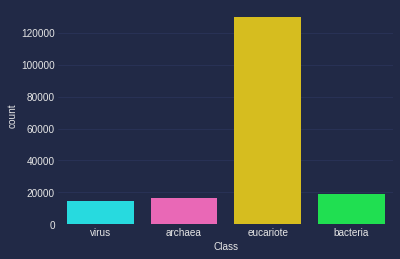

In [10]:
sns.countplot(data=data, x="Class")

## Because we have unbalanced data, we can use a Weighted Random Sampler or Weighted Cross Entropy Loss to train our models.

#### Models building

In [11]:
from models import LSTMnet2, LSTMnet

# I used the same settings to set both networks, but you can customize for each if you want

embedding_dim = 100
lstm1_dim = 64
dropout1 = 0.2
lstm2_dim = 32
dropout2 = 0.2
num_layers = 2
hidden_dim = 64
out_dim = len(classes)

#### Model with 2 lstm , use model_le for data encoded by label encoder and model_kmer for data encoded by kmer encoder

model1_le = LSTMnet2(len(bin_vocab)+1, embedding_dim, lstm1_dim, dropout1, lstm2_dim, dropout2, num_layers, hidden_dim, out_dim)
# don't forget to pass to the actual device
model1_le = model1_le.to(device)


#### Model with 1 lstm

model2_kmer = LSTMnet(len(kmer_vocab)+1, embedding_dim, lstm1_dim, hidden_dim, out_dim, dropout1)
model2_kmer = model2_kmer.to(device)

/home/jememaga/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### 1 - Weighted Random Sampler

In [12]:
from data_process import get_collate_fn, get_weigths_for_wsampler

# this collate function is essential, don't forget this !
collate_fn = get_collate_fn()

# bin_train_dataset and kmer_train_dataset have the same length, so you can use the same sampler
sampler = WeightedRandomSampler(get_weigths_for_wsampler(train_list), len(bin_train_dataset), replacement=True)

# you can change it 
batch_size = 100

bin_train_loader = DataLoader(bin_train_dataset, batch_size=batch_size, sampler=sampler, collate_fn=collate_fn, drop_last=False)
bin_valid_loader = DataLoader(bin_valid_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, drop_last=False)
bin_test_loader = DataLoader(bin_test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, drop_last=False)

#### Train the model 1 with label encoded data

In [13]:
from engine import train

# loss function
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

# optimizer is set to Adam by default in the train function !!! 

CrossEntropyLoss()

In [14]:
## train model with label encoder
results = train(model=model1_le, loss_fn=loss_fn, device=device, train_loader=bin_train_loader, valid_loader=bin_valid_loader, n_epochs=10, patience=4, n_classes=len(classes))

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

**************************************************
Epoch : 1
Train --> loss : 1.072168323857728 | acc 0.663582175835366
Evaluation --> loss 0.9453537881374359 | acc 0.8052407387230132
**************************************************


  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training takes 6020.823197364807 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


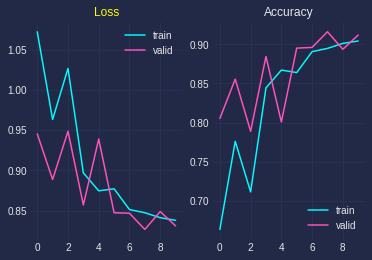

In [15]:
plt.subplot(1, 2, 1)
plt.title("Loss", color='yellow')
plt.plot(results["train_loss"], label='train')
plt.plot(results["valid_loss"], label='valid')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(results["train_acc"], label='train')
plt.plot(results["valid_acc"], label='valid')
plt.legend()

plt.show()

#### Test

In [16]:
from engine import test

results_model1_bin = test(model1_le, bin_test_loader, device)

  0%|          | 0/180 [00:00<?, ?it/s]

/home/jememaga/engine.py:227: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results["y_true"] = np.array(results["y_true"])
/home/jememaga/engine.py:228: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results["y_pred"] = np.array(results["y_pred"])


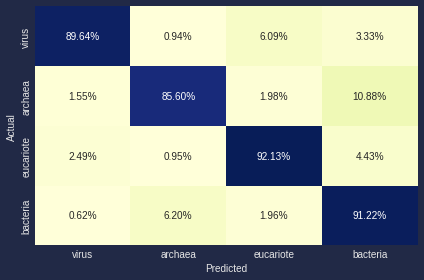

In [17]:
from sklearn.metrics import confusion_matrix

cm_model1_bin = confusion_matrix(results_model1_bin["y_true"], results_model1_bin["y_pred"])

# Normalise
cm_model1_bin = cm_model1_bin.astype('float') / cm_model1_bin.sum(axis=1)[:, np.newaxis]

f, ax = plt.subplots(1, 1, figsize=(6, 4))

g1 = sns.heatmap(cm_model1_bin, annot=True, fmt='.2%', xticklabels=classes, yticklabels=classes, cbar=False, ax=ax, cmap="YlGnBu")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

### 2 - Weighted Cross Entropy (without weighted random sampler)

In [18]:
from data_process import get_weights_for_cross_entropy

loss_fn = nn.CrossEntropyLoss(weight=get_weights_for_cross_entropy(train_list).to(device))


In [19]:
kmer_train_loader = DataLoader(kmer_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=False)
kmer_valid_loader = DataLoader(kmer_valid_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, drop_last=False)
kmer_test_loader = DataLoader(kmer_test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, drop_last=False)

#### Train the model2 with kmers data

In [20]:
## train model with label encoder
results = train(model=model2_kmer, loss_fn=loss_fn, device=device, train_loader=kmer_train_loader, valid_loader=kmer_valid_loader, n_epochs=20, patience=3, n_classes=len(classes))

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

**************************************************
Epoch : 1
Train --> loss : 1.1315172051023874 | acc 0.5859243528028855
Evaluation --> loss 1.0186018225219515 | acc 0.8479074084096485
**************************************************


  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

!!!
Early stopping at epoch : 8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training takes 2961.8702409267426 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


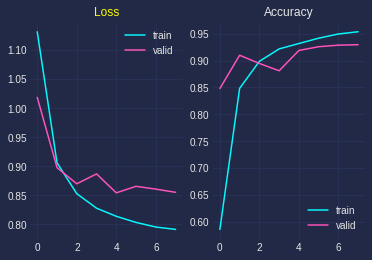

In [21]:
plt.subplot(1, 2, 1)
plt.title("Loss", color='yellow')
plt.plot(results["train_loss"], label='train')
plt.plot(results["valid_loss"], label='valid')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(results["train_acc"], label='train')
plt.plot(results["valid_acc"], label='valid')
plt.legend()

plt.show()

In [22]:
from engine import test

results_model2_kmer = test(model2_kmer, kmer_test_loader, device)

  0%|          | 0/180 [00:00<?, ?it/s]

/home/jememaga/engine.py:227: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results["y_true"] = np.array(results["y_true"])
/home/jememaga/engine.py:228: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results["y_pred"] = np.array(results["y_pred"])


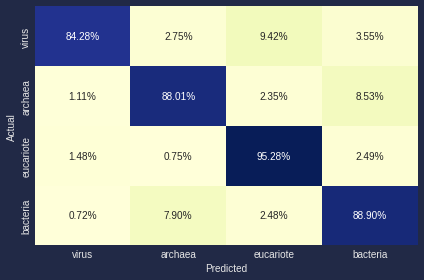

In [23]:
from sklearn.metrics import confusion_matrix

cm_model2_kmer = confusion_matrix(results_model2_kmer["y_true"], results_model2_kmer["y_pred"])

# Normalise
cm_model2_kmer = cm_model2_kmer.astype('float') / cm_model2_kmer.sum(axis=1)[:, np.newaxis]

f, ax = plt.subplots(1, 1, figsize=(6, 4))

g1 = sns.heatmap(cm_model2_kmer, annot=True, fmt='.2%', xticklabels=classes, yticklabels=classes, cbar=False, ax=ax, cmap="YlGnBu")

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

Thanks !